In [7]:
# utils 
from utils import ML_, Preprocessing_, Postprocessing_, Visualize_

# math libraries
import numpy as np
from scipy.constants import g

# df libraries
import xarray as xr
import pandas as pd
import geopandas as gpd
import rioxarray

# visualization-projection libraries
import matplotlib.pyplot as plt
import cartopy
from shapely.geometry import mapping

# system libraries
import os
import glob

# warnings
import warnings
warnings.filterwarnings('ignore')

# autoload
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
class classifyRegions:
    
    def __init__(self, ds_path, shp_path, start_year, end_year, crs, lon_name, lat_name):
        
        self.ds_path    = ds_path
        self.shp_path   = shp_path
        self.start_year = start_year
        self.end_year   = end_year
        self.crs        = crs
        self.lon_name   = lon_name
        self.lat_name   = lat_name
        
    def open_xarray(self, *args, **kwargs):
        
        ds = xr.open_dataset(self.ds_path, *args, **kwargs)
        ds.sel(time=slice(self.start_year, self.end_year))
        return ds
    
    def assign_proj_info(self, ds, *args, **kwargs):
        return Preprocessing_.write_crs_info(ds, self.crs)  
    
    def time_mean(self, ds):
        return ds.mean(dim='time')              
    
    def interpolate_xy(self, ds, interp_size):
        return Preprocessing_.interpolate_xy(ds, self.lon_name, self.lat_name, interp_size)
    
    def clip_area(self, ds):
        return Preprocessing_.clip_area(ds, self.shp_path, self.lon_name, self.lat_name)
    
    def xr_to_pd(self, ds, with_na=False):
        return Preprocessing_.xr_to_pd(ds, self.lon_name, self.lat_name, with_na)
    
    def get_var_names(self, df):
        return [col for col in df.columns if col not in [self.lat_name, self.lon_name, 'lat_lon']]
    
    def standardize(self, df):
        return ML_.standardize(df)
    
    def Algo_KMeans(self, X, n_clusters, *args, **kwargs):
        return ML_.Algo_KMeans(X, n_clusters, *args, **kwargs)
    
    def Algo_DBScan(self, X, epsilon, min_samples, *args, **kwargs):
        return ML_.Algo_DBScan(X, epsilon, min_samples, *args, **kwargs)
    
    def predict(self, fit, X):
        return ML_.predict(fit, X)
    
    def pred_to_df(self, y_pred, df):
        return ML_.pred_to_df(y_pred, df)
    
    def pd_to_xr(self, df_with_na, df_pred):
        return Postprocessing_.pd_to_xr(df_with_na, df_pred, self.lon_name, self.lat_name)

## 1. General Parameters

In [3]:
# paths
ds_feature  = 'Single'
ds_path     = glob.glob(f'Dataset/*{ds_feature}*')[0]
shp_prov    = glob.glob('Shapefiles/*provinces.shp*')[0]

# coordinate parameters
start_year  = '1981'
end_year    = '2010'
lon_name    = 'longitude'
lat_name    = 'latitude'

# projection parameters
globe       = cartopy.crs.Globe()
crs         = cartopy.crs.PlateCarree(globe=globe)

# interpolation parameters
interp_size = 8

### 2. Define Dataset for use in ML

In [4]:
# initiate instance
classification = classifyRegions(ds_path, shp_prov,
                                 start_year, end_year,
                                 crs, lon_name, lat_name)

# open xr.Dataset
ds         = classification.open_xarray()
# assign projection to xr.Dataset
ds         = classification.assign_proj_info(ds)
# average over time
ds_mean    = classification.time_mean(ds)
# interpolate the xr.Dataset
interp_ds  = classification.interpolate_xy(ds_mean, interp_size)
# clip xr.Dataset on given area
clip_ds    = classification.clip_area(interp_ds)
# convert xr.Dataset into pd.DataFrame with nans dropped
df         = classification.xr_to_pd(clip_ds, with_na=False)
# convert xr.Dataset into pd.DataFrame with nans remain
df_with_na = classification.xr_to_pd(clip_ds, with_na=True)


# get only variable names from pd.DataFrame
variables  = classification.get_var_names(df)
#variables  = ['tp']

# define X with only meteorological variables
X          = df[variables]
# standardize meteorological data
X_trans    = classification.standardize(X)

### 3. K-Means Model

In [5]:
# ML Parameters
n_clusters = 6

# define model
fit        = classification.Algo_KMeans(X_trans, n_clusters, random_state=0)
y_pred     = classification.predict(fit, X_trans)

# convert prediction pd.DataFrame to xr.Dataset
df_pred    = classification.pred_to_df(y_pred, df)
ds_pred    = classification.pd_to_xr(df_with_na, df_pred)
ds_pred    = classification.assign_proj_info(ds_pred)

#### 3.1 Plot

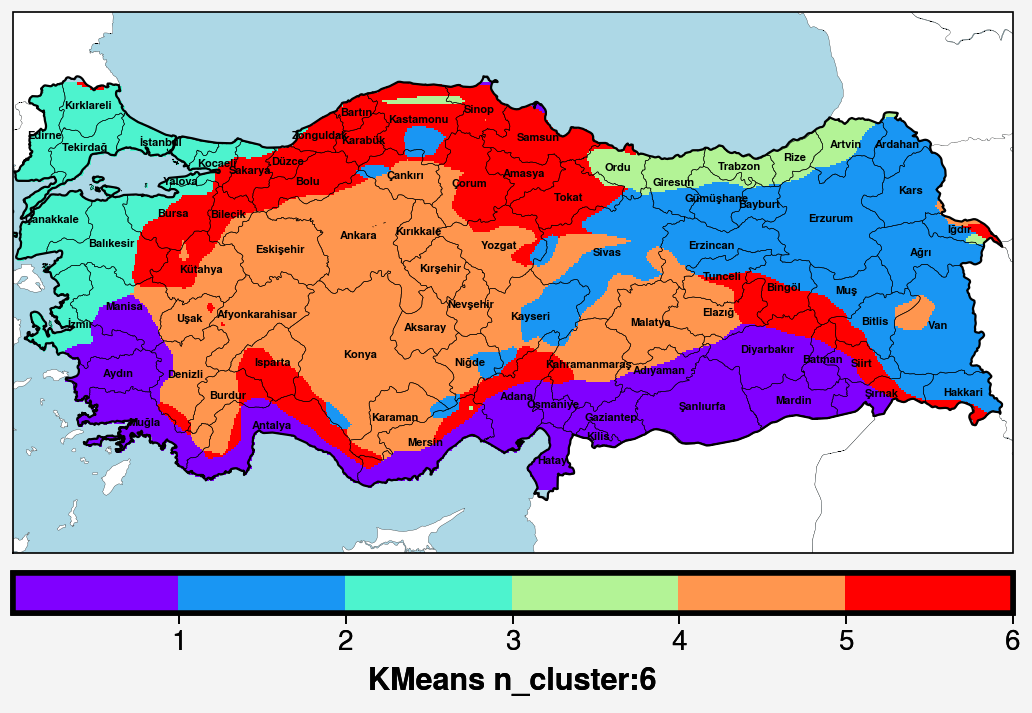

In [21]:
# cmap, vmin, vmax, ticks
cmap=plt.get_cmap('rainbow')
cbar_name = f'KMeans n_cluster:{n_clusters}'
vmin=0
vmax=n_clusters
ticks = np.arange(1,n_clusters+1)

# variable
variable = 'pred'
Visualize_.plot_whole(ds_pred, cmap,
                      vmin, vmax,
                      ticks, variable,
                      crs, shp_prov,
                      lon_name, lat_name,
                      cbar_name)

### 4. NN Model